In [9]:
# Import Libraries

import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from torchvision.models import AlexNet_Weights
from torch.utils.data import DataLoader, random_split

from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Specify the path to the locally saved dataset
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
train_dataset = datasets.ImageFolder(train_data_dir)

In [20]:
# Preprocessing steps used for imagenet dataset with the original AlexNet model
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert grayscale to RGB
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=200, threshold=3))),  # Sharpening
    transforms.ToTensor()
])

# preprocessed dataset
preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

# DataLoader for the dataset
data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [5]:
# Paths for each class
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

# Printing the MRI counts
print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8960

Total MRIs in the dataset = 33984


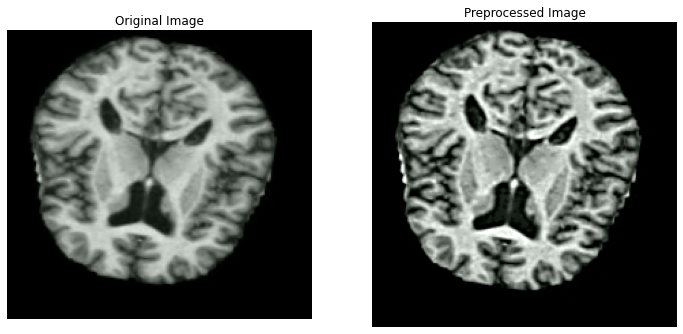

In [21]:
# Sample MRI before and after preprocessing

sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

In [22]:
# Dataset splitting 

train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [34]:
# custom model inspired by the AlexNet architecture 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        return self.leakyrelu(self.bn(self.conv(x)))
    
class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv3 = nn.Conv2d(inter_channels, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.leakyrelu(self.bn1(self.conv1(x)))
        x = self.leakyrelu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        return self.leakyrelu(x)
    
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomAlexNet, self).__init__()
        # Aligning with AlexNet's initial layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Custom Bottleneck layer
            Bottleneck(192, 256, 384),
            # Following AlexNet's structure
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Assuming output size calculation is correct
        output_size = 256 * 6 * 6

        # Classifier structure aligned with AlexNet
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


pretrained_alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# Create an instance of the CustomAlexNet model
TL_model = CustomAlexNet(num_classes=4)

# Transfer and freeze the weights for the matching layers
for i, ((name1, module1), (name2, module2)) in enumerate(zip(TL_model.features.named_children(), pretrained_alexnet.features.named_children())):
    if i < 5:  # Adjust this index based on where your custom layers start
        module1.load_state_dict(module2.state_dict())
        for param in module1.parameters():
            param.requires_grad = False

In [35]:
summary(TL_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]          74,112
       BatchNorm2d-8          [-1, 384, 13, 13]             768
            Conv2d-9          [-1, 256, 13, 13]          49,408
      BatchNorm2d-10          [-1, 256, 13, 13]             512
        LeakyReLU-11          [-1, 256, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         590,080
      BatchNorm2d-13          [-1, 256, 13, 13]             512
        LeakyReLU-14          [-1, 256,

In [36]:
print(TL_model)

CustomAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Bottleneck(
      (conv1): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 384, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)

In [38]:
# code to train and evaluate the Custom AlexNet model from scratch (with some pre-trained weights)

TL_model = TL_model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(TL_model.parameters(), lr=0.001)

def train_epoch(epoch_index, train_loader, model):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model.train()  # Set model to training mode
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model.eval()  
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

# Training loop
num_epochs = 15
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, TL_model)
    val_loss, val_acc = validate_epoch(epoch, val_loader, TL_model)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

Epoch 1 [train] Progress:   1%|▏           | 9/744 [00:49<1:07:18,  5.49s/batch]


KeyboardInterrupt: 